myAgro Food Security Impact Analysis
=
#### Nessa Scalora, Data Scientist
##### November, 2025

## Get Tools & Data

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from scipy import stats

import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm

In [2]:
# Import CSV data--replace file path as necessary
path = 'survey_data_clean_anonymized.csv'
df_raw = pd.read_csv(path)

In [3]:
# Copy imported dataframe
df = df_raw.copy()

## Features

In [4]:
# Treatment columns
continuous_treatments = ['cowpea_hectares',
                         'maize_hectares',
                         'millet_hectares',
                         'okra_hectares',
                         'peanut_hectares',
                         'rice_hectares',
                         'roselle_hectares',
                         'sorghum_hectares',
                         'watermelon_hectares']

all_continuous_treatments = continuous_treatments + ['hectares_delivered_before_2023']
all_treatments = all_continuous_treatments + ['fertilizer_25kg']

In [5]:
# Specify main crop type columns (0/1 one-hot, excludes "other")
main_crop_cols = ['cashew',
                  'peanut',
                  'bissap',
                  'cotton',
                  'okra',
                  'maize',
                  'millet',
                  'cowpea',
                  'watermelon',
                  'sweet_potato',
                  'rice',
                  'sorghum',
                  'tomato']

## Data Preparation

In [6]:
# Copy data
pre_scaled_prepped_df = df.copy()

In [7]:
# Create a binary variable for the fertilizer treatment (clients either received the 25kg of fertilizer gift or not)
pre_scaled_prepped_df['fertilizer_25kg'] = pre_scaled_prepped_df['fertilizer_hectares'].apply(lambda x: 1 if x>0 else 0)

In [8]:
# Add a variable containing the season (lean vs non-lean) based on data collection period
lean_season = [6,7,8]
pre_scaled_prepped_df['food_security_season'] = pre_scaled_prepped_df['data_collection_period_encoded'].apply(lambda x: 'lean_season' if x in lean_season else 'non_lean_season')

In [9]:
# Normalize features

In [10]:
# Columns to scale
cols_to_scale = ['t_c', 'sin_t', 'cos_t']
cols_to_scale.extend(all_continuous_treatments)

In [11]:
# Initialize scaler
scaler = StandardScaler()

In [12]:
# Fit and transform only the selected columns
mm_df = pre_scaled_prepped_df.copy()
mm_df[cols_to_scale] = scaler.fit_transform(mm_df[cols_to_scale])

In [13]:
# FYI after scaling the data, the treatment variables for control farmers are no longer 0. They are the values
# displayed below for all control farmers
# mm_df[mm_df['myagro']==0][[c for c in mm_df.columns if c in all_continuous_treatments]].drop_duplicates()

## LMM

In [14]:
# Copy data
modeling_df = mm_df.copy()

In [15]:
# Lean season data
ls_modeling_df = modeling_df[modeling_df['food_security_season']=='lean_season'].copy()

In [16]:
# Build year-round fixed effects formula
fixed_effects = (
    "country + C(household_cohort) + propensity + " +
    " + ".join(all_treatments) + " + "
    "t_c + sin_t + cos_t"
)

formula = f"rcsi ~ {fixed_effects}"

In [17]:
# Build lean season fixed effects formula (excludes cohort because lean season data includes only one)
ls_fixed_effects = (
    "country + propensity + " +
    " + ".join(all_treatments) + " + "
    "t_c + sin_t + cos_t"
)

ls_formula = f"rcsi ~ {ls_fixed_effects}"

In [18]:
# Fit the year-round model
model = smf.mixedlm(formula,                                   # fixed effects formula
                    data=modeling_df,                          # data
                    groups=modeling_df["household_case_id"],   # household random intercept
                    re_formula="~t_c")                         # time random slope

In [19]:
# Save year-round results
result = model.fit(reml=False, method='lbfgs')
# print(result.summary())

In [20]:
# Fit the lean season model
ls_model = smf.mixedlm(ls_formula,                                   # fixed effects formula
                       data=ls_modeling_df,                          # data
                       groups=ls_modeling_df["household_case_id"],   # household random intercept
                       re_formula="~t_c")                            #time random slope

In [21]:
# Save lean season results
ls_result = ls_model.fit(reml=False, method='lbfgs')
# print(ls_result.summary())

## Get Model Results

### Helper Functions

In [22]:
def unscale_mixedlm(result, cols_to_scale, means, stds):
    """
    Convert coefficients, SEs, and confidence intervals from a scaled mixedlm model
    back to the original feature units.

    Parameters
    ----------
    result : statsmodels MixedLMResults
        Fitted model result (from smf.mixedlm(...).fit()) using scaled features.
    cols_to_scale : list of str
        List of feature names in the model that were standardized.
    means : list or array-like
        Means of the original (unscaled) features, in same order as cols_to_scale.
    stds : list or array-like
        Standard deviations of the original features, in same order as cols_to_scale.

    Returns
    -------
    summary_df : pd.DataFrame
        DataFrame with coefficients, standard errors, t-values, p-values,
        and 95% confidence intervals on the *original scale*.
    """
    params = result.params.copy()
    bse = result.bse.copy()

    params_orig = params.copy()
    bse_orig = bse.copy()

    # --- 1. Transform coefficients and SEs for each scaled feature ---
    for i, feat in enumerate(cols_to_scale):
        if feat in params.index:
            params_orig[feat] = params[feat] / stds[i]
            bse_orig[feat] = bse[feat] / stds[i]

    # --- 2. Adjust intercept coefficient ---
    if 'Intercept' in params.index:
        intercept_adj = sum(params[feat] * means[i] / stds[i]
                            for i, feat in enumerate(cols_to_scale)
                            if feat in params.index)
        params_orig['Intercept'] = params['Intercept'] - intercept_adj
        # Note: Intercept SE is approximate (ignores covariance terms)

    # --- 3. Recalculate t-values and p-values ---
    t_vals = params_orig / bse_orig
    p_vals = 2 * (1 - stats.t.cdf(np.abs(t_vals), df=result.df_resid))

    # --- 4. Recalculate confidence intervals ---
    t_critical = stats.t.ppf(0.975, df=result.df_resid)
    conf_int_orig = pd.DataFrame({
        '[0.025': params_orig - t_critical * bse_orig,
        '0.975]': params_orig + t_critical * bse_orig
    }, index=params_orig.index)

    # --- 5. Build summary table ---
    params_orig = round(params_orig,2)
    summary_df = pd.concat(
        [params_orig, bse_orig, t_vals, pd.Series(p_vals, index=params_orig.index),
         conf_int_orig], axis=1
    )
    summary_df.columns = ['coef', 'std err', 't', 'P>|t|', '[0.025', '0.975]']

    return summary_df

### Execute Transformations

#### Get Model Results on Original Feature Scale

In [23]:
# Get original means and stds (re-scale)
means = scaler.mean_
stds = scaler.scale_

In [24]:
# Transform year-round coefficients back to the original feature scales
results_summary_og_scale_df = unscale_mixedlm(result, cols_to_scale, means, stds)

In [25]:
# Print year-round results (original scale)
# results_summary_og_scale_df

In [26]:
# Transform lean season coefficients back to the original feature scales
ls_results_summary_og_scale_df = unscale_mixedlm(ls_result, cols_to_scale, means, stds)

In [27]:
# Print lean season results (original scale)
# ls_results_summary_og_scale_df

#### Statistically Significant Results (*P*≤.05)

In [28]:
# Year-round results
significant_results_summary_df = results_summary_og_scale_df[results_summary_og_scale_df['P>|t|']<=0.05]

In [29]:
# Print significant year-round results
# significant_results_summary_df

In [30]:
# Lean season results
ls_significant_results_summary_df = ls_results_summary_og_scale_df[ls_results_summary_og_scale_df['P>|t|']<=0.05]

In [31]:
# Print significant lean season results
# ls_significant_results_summary_df

#### Not Significant Results (*P*≤.05)

In [32]:
# Year-round results
insignificant_results_summary_df = results_summary_og_scale_df[results_summary_og_scale_df['P>|t|']>0.05]

In [33]:
# Print insignificant year-round results
# insignificant_results_summary_df

In [34]:
# Lean season results
ls_insignificant_results_summary_df = ls_results_summary_og_scale_df[ls_results_summary_og_scale_df['P>|t|']>0.05]

In [35]:
# Print insignificant lean season results
# ls_insignificant_results_summary_df

#### Not Significant Results (*P*≤.05) but Significant (*P*≤.10)

In [36]:
# Year-round results
significant_10_results_summary_df = results_summary_og_scale_df[(results_summary_og_scale_df['P>|t|']>0.05) & (results_summary_og_scale_df['P>|t|']<=0.1)]

In [37]:
# Print significant 10% level year-round results
# significant_10_results_summary_df

In [38]:
# Print significant 10% level lean season results
ls_significant_10_results_summary_df = ls_results_summary_og_scale_df[(ls_results_summary_og_scale_df['P>|t|']>0.05) & (ls_results_summary_og_scale_df['P>|t|']<=0.1)]

In [39]:
# ls_significant_10_results_summary_df

## Get Model Results by Average Package Size
To better understand impact, we will interpret the model coefficients based on average hectarage planted (package size) instead of per hectare. This is because most clients purchase packages with inputs that cover only a small portion of a hectare.

In [40]:
# Get relevant columns
crop_group_cols = ['household_case_id']
crop_group_cols.extend(all_treatments)

### Year-round

In [41]:
# Dataframe with relevant columns and myAgro rows
myagro_crop_groups_df = pre_scaled_prepped_df[pre_scaled_prepped_df['control_myagro']=='myagro'][crop_group_cols]\
                                .drop_duplicates()\
                                .copy()

In [42]:
# Column with the the client's delivered package size
myagro_crop_groups_df['hectares'] = myagro_crop_groups_df[continuous_treatments].sum(axis=1)

In [43]:
# Get binary columns for each treatment (planted the product or not)
unique_household_treatment_cols = []
for c in all_treatments:
    if c=='hectares_delivered_before_2023':
        new_c = 'delivered_before_2023'
    else:
        new_c = f"{c[:-9]}"
    unique_household_treatment_cols.append(new_c)
    myagro_crop_groups_df[new_c] = myagro_crop_groups_df[c].apply(lambda x: 1 if x>0 else 0)

In [44]:
# Average hectares planted per unique myAgro household for each type of treatment
avg_ha_planted_per_treatment_df = pd.DataFrame(myagro_crop_groups_df[all_treatments]\
                                       .drop('fertilizer_25kg', axis=1)\
                                       .replace(0, None)\
                                       .mean()\
                                       .sort_values())\
                                    .rename(columns={0: 'average_hectares_planted'})

In [45]:
# Join model results to get the treatment coefficients
full_year_average_results_df = avg_ha_planted_per_treatment_df.join(results_summary_og_scale_df[['coef']])
# Get the column with average impact
full_year_average_results_df['average_impact_on_rcsi'] = full_year_average_results_df['average_hectares_planted'] * full_year_average_results_df['coef']
# Round results
full_year_average_results_df['average_impact_on_rcsi'] = full_year_average_results_df['average_impact_on_rcsi'].apply(lambda x: round(x, 2))

In [46]:
# Year-round results
# full_year_average_results_df

### Lean Season

In [47]:
# Lean season dataframe with relevant columns and myAgro rows
ls_myagro_crop_groups_df = pre_scaled_prepped_df[(pre_scaled_prepped_df['control_myagro']=='myagro') &
                                                 (pre_scaled_prepped_df['food_security_season']=='lean_season')]\
                                [crop_group_cols].drop_duplicates().copy()

In [48]:
# Column with the the client's delivered package size
ls_myagro_crop_groups_df['hectares'] = ls_myagro_crop_groups_df[continuous_treatments].sum(axis=1)

In [49]:
# Get binary columns for each treatment (planted the product or not)
ls_unique_household_treatment_cols = []
for c in all_treatments:
    if c=='hectares_delivered_before_2023':
        new_c = 'delivered_before_2023'
    else:
        new_c = f"{c[:-9]}"
    ls_unique_household_treatment_cols.append(new_c)
    ls_myagro_crop_groups_df[new_c] = ls_myagro_crop_groups_df[c].apply(lambda x: 1 if x>0 else 0)

In [50]:
# Average hectares planted per unique myAgro household for each type of treatment
ls_myagro_crop_groups_df[all_treatments].drop('fertilizer_25kg', axis=1).replace(0, None).mean().sort_values()

watermelon_hectares               0.010263
okra_hectares                     0.012905
roselle_hectares                   0.02584
rice_hectares                         0.05
cowpea_hectares                   0.061094
sorghum_hectares                     0.125
peanut_hectares                   0.150673
maize_hectares                      0.1625
millet_hectares                    0.40001
hectares_delivered_before_2023     0.69679
dtype: object

In [51]:
# Average hectares planted per unique myAgro household for each type of treatment
ls_avg_ha_planted_per_treatment_df = pd.DataFrame(ls_myagro_crop_groups_df[all_treatments]\
                                       .drop('fertilizer_25kg', axis=1)\
                                       .replace(0, None)\
                                       .mean()\
                                       .sort_values())\
                                    .rename(columns={0: 'average_hectares_planted'})

In [52]:
# Join model results to get the treatment coefficients
lean_season_average_results_df = ls_avg_ha_planted_per_treatment_df.join(ls_results_summary_og_scale_df[['coef']])
# Get the column with average impact
lean_season_average_results_df['average_impact_on_rcsi'] = lean_season_average_results_df['average_hectares_planted'] * lean_season_average_results_df['coef']
# Round results
lean_season_average_results_df['average_impact_on_rcsi'] = lean_season_average_results_df['average_impact_on_rcsi'].apply(lambda x: round(x, 2))

In [53]:
# Lean season results
# lean_season_average_results_df

## IPTW-Weighted Average rCSI

In [54]:
weighted_rcsi_df = mm_df.copy()

In [55]:
# Get inverse probability of treatment weighted rCSI
weighted_rcsi_df = weighted_rcsi_df.assign(ps_weight=weighted_rcsi_df\
                                           .apply(lambda row: 1/row['propensity'] if row['myagro']==1
                                                          else 1/(1-row['propensity']),
                                                  axis=1))
weighted_rcsi_df['weighted_rcsi'] = weighted_rcsi_df['rcsi'] * weighted_rcsi_df['ps_weight']

In [56]:
def calculate_ps_weighted_avg(group):
        """Calculates the propensity-score-weighted average of rCSI."""
        return group['weighted_rcsi'].sum() / group['ps_weight'].sum()

In [57]:
# Get weighted average rCSI by data collection period
dcp_weighted_rcsi_df = pd.DataFrame(weighted_rcsi_df.groupby(['data_collection_period_encoded',
                                                              'country',
                                                              'control_myagro'])\
                                                    .apply(calculate_ps_weighted_avg,
                                                           include_groups=False))

In [58]:
# Compare to normal mean
dcp_weighted_rcsi_compare_df = dcp_weighted_rcsi_df.join(weighted_rcsi_df.groupby(['data_collection_period_encoded',
                                                                                   'country',
                                                                                   'control_myagro'])\
                                                                         .agg({'rcsi': 'mean'}),
                                                         how='left')

dcp_weighted_rcsi_compare_df.columns = ['iptw_average_rcsi', 'average_rcsi']
dcp_weighted_rcsi_compare_df['diff'] = dcp_weighted_rcsi_compare_df['iptw_average_rcsi'] - dcp_weighted_rcsi_compare_df['average_rcsi']

In [59]:
# Get clean weighted averages tables for each country
dcp_iptw_rcsi_df = dcp_weighted_rcsi_compare_df[['iptw_average_rcsi']]

In [60]:
# Data collection period labels
dcp_label_map = weighted_rcsi_df[[c for c in weighted_rcsi_df.columns if 'data_collection' in c]].drop_duplicates()

In [61]:
dcp_iptw_rcsi_df.head()

iptw_average_rcsi
data_collection_period_encoded country control_myagro                   
1                              Mali    control                 13.922609
                                       myagro                   2.220204
                               Senegal control                  9.701671
                                       myagro                   4.689132
2                              Mali    control                  9.135738

In [62]:
ml_dcp_iptw_rcsi_df = dcp_iptw_rcsi_df.loc[(slice(None), 'Mali'), :].droplevel(level=1).unstack()
ml_dcp_iptw_rcsi_df.columns = ['control', 'myagro']
ml_dcp_iptw_rcsi_df.reset_index(inplace=True)

sn_dcp_iptw_rcsi_df = dcp_iptw_rcsi_df.loc[(slice(None), 'Senegal'), :].droplevel(level=1).unstack()
sn_dcp_iptw_rcsi_df.columns = ['control', 'myagro']
sn_dcp_iptw_rcsi_df.reset_index(inplace=True)

In [63]:
def plot_iptw_average_by_dcp_arm(df,
                                 dcp_label_map,
                                 country: str,
                                 outcome: str):
    # Set a nicer font
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['font.size'] = 10

    plt.figure(figsize=(12, 8))  # Made taller (was 12, 6)

    # Define colors for each arm
    colors = {'control': 'gold', 'myagro': 'green'}

    for arm in ['control', 'myagro']:
        # Plot the line
        plt.plot(df['data_collection_period_encoded'],
                 df[arm],
                 label=f'{arm} households',
                 marker='o',
                 color=colors[arm],
                 markersize=7,
                 linewidth=2)

        # Add value labels on each point - BIGGER and HIGHER
        for x, y in zip(df['data_collection_period_encoded'], df[arm]):
            plt.text(x, y + 0.8, f'{y:.2f}',  # Adjusted offset for smaller range
                    fontsize=11,
                    ha='center',
                    va='bottom',
                    color=colors[arm],
                    fontweight='bold')

    # Set y-axis range
    plt.ylim(0, 30)

    # Add red vertical line at x=6
    plt.axvline(x=6, color='red', linestyle='--', alpha=0.7, linewidth=1.5)

    # Shade and label the "Lean Season" area (6 to 8)
    plt.axvspan(6, 8, alpha=0.1, color='red')
    plt.text(7, 28.5, 'Lean Season',  # Adjusted position for smaller range
            ha='center',
            fontsize=11,
            color='darkred',
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    # Update x-axis labels using the mapping
    # Get unique data collection periods and sort them
    unique_periods = sorted(df['data_collection_period_encoded'].unique())

    # Create label mapping from dcp_label_map
    label_dict = dict(zip(dcp_label_map['data_collection_period_encoded'],
                         dcp_label_map['data_collection_period_eng']))

    # Set x-axis ticks and labels
    plt.xticks(unique_periods,
              [label_dict.get(period, str(period)) for period in unique_periods],
              rotation=45,
              ha='right')

    plt.xlabel('Data Collection Period', fontsize=11, fontweight='bold')
    plt.ylabel(f'{outcome} IPTW Weighted Mean (0-56)', fontsize=11, fontweight='bold')  # Added (0-56)
    plt.suptitle(f'{country} {outcome} Weighted Mean by Data Collection Period',
                fontsize=13, fontweight='bold', y=0.98)
    plt.title('Data collection periods spanned ~1.5 months each',
             fontsize=10, fontweight='normal', pad=15)
    plt.legend(loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

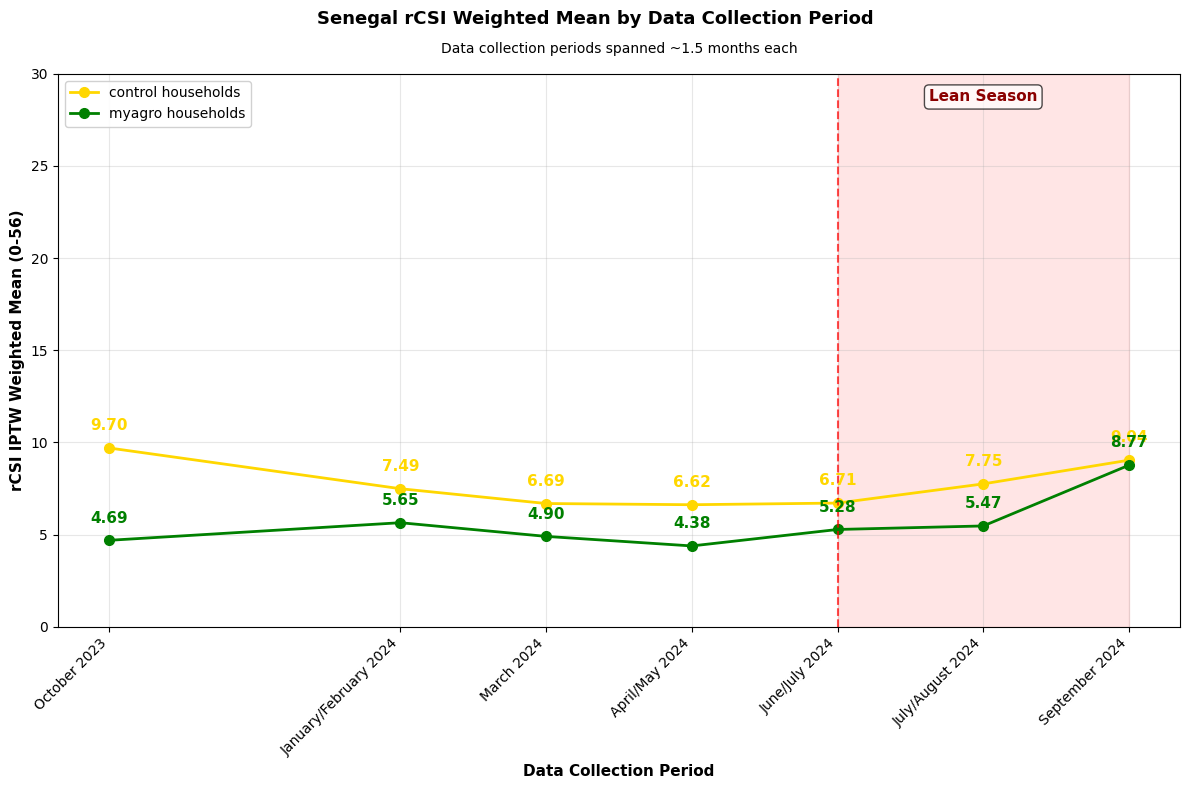

In [64]:
plot_iptw_average_by_dcp_arm(sn_dcp_iptw_rcsi_df, dcp_label_map, 'Senegal', 'rCSI')

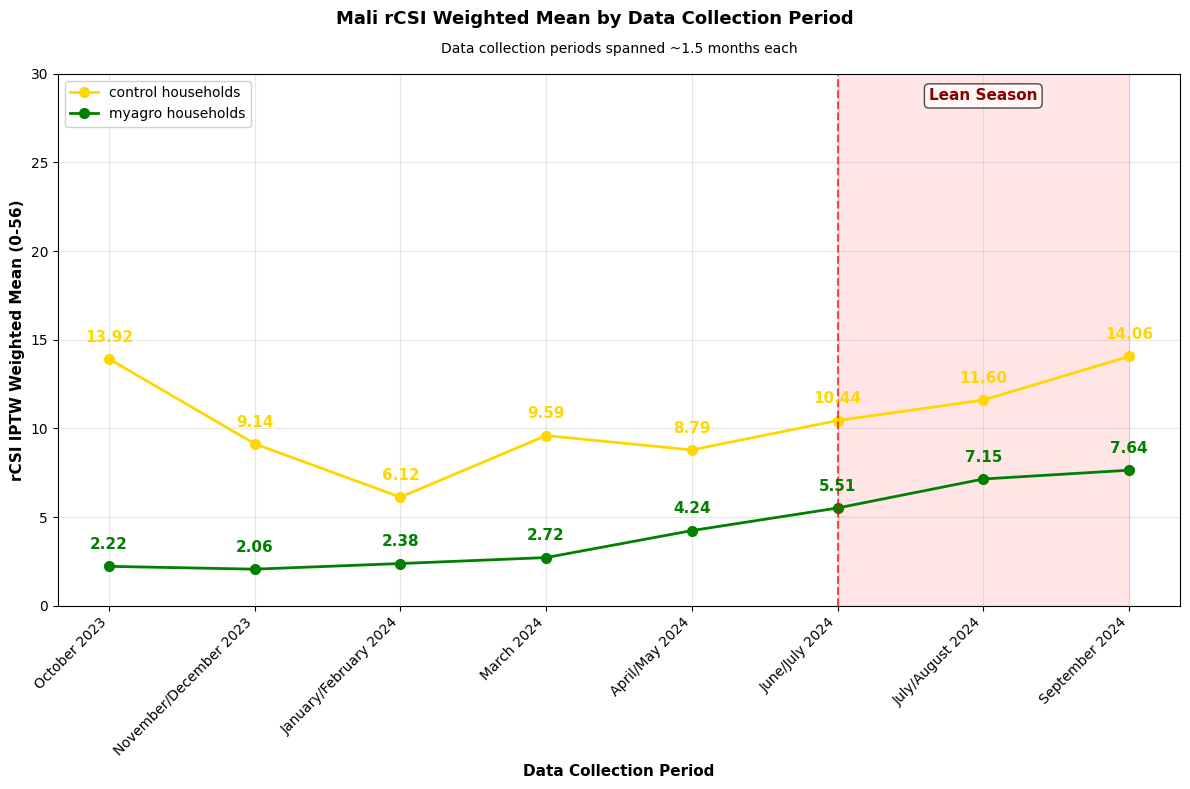

In [65]:
plot_iptw_average_by_dcp_arm(ml_dcp_iptw_rcsi_df, dcp_label_map, 'Mali', 'rCSI')

## rCSI Descriptive Statistics
For Reporting

### Year-round rCSI

In [66]:
# Descriptive statistics of rCSI full dataset
modeling_df['rcsi'].describe()

count    11854.000000
mean         7.061667
std          9.287600
min          0.000000
25%          0.000000
50%          4.000000
75%         11.000000
max         56.000000
Name: rcsi, dtype: float64

In [67]:
# Descriptive statistics of rCSI: myAgro data
modeling_df[modeling_df['myagro']==1]['rcsi'].describe()

count    5939.000000
mean        4.743728
std         7.061797
min         0.000000
25%         0.000000
50%         1.000000
75%         7.000000
max        51.000000
Name: rcsi, dtype: float64

In [68]:
# Descriptive statistics of rCSI: control data
modeling_df[modeling_df['myagro']==0]['rcsi'].describe()

count    5915.000000
mean        9.389011
std        10.582972
min         0.000000
25%         0.000000
50%         6.000000
75%        15.000000
max        56.000000
Name: rcsi, dtype: float64

### Lean Season rCSI

In [69]:
# Descriptive statistics of rCSI full dataset
ls_modeling_df['rcsi'].describe()

count    4802.000000
mean        8.293628
std        10.492794
min         0.000000
25%         0.000000
50%         5.000000
75%        13.000000
max        56.000000
Name: rcsi, dtype: float64

In [70]:
# Descriptive statistics of rCSI: myAgro data
ls_modeling_df[ls_modeling_df['myagro']==1]['rcsi'].describe()

count    2400.000000
mean        6.471667
std         8.526546
min         0.000000
25%         0.000000
50%         3.000000
75%        11.000000
max        50.000000
Name: rcsi, dtype: float64

In [71]:
# Descriptive statistics of rCSI: control data
ls_modeling_df[ls_modeling_df['myagro']==0]['rcsi'].describe()

count    2402.000000
mean       10.114072
std        11.869145
min         0.000000
25%         0.000000
50%         6.000000
75%        16.000000
max        56.000000
Name: rcsi, dtype: float64

### Analysis of IPC Phases
Year-round and by food security season

#### Year-round

In [72]:
count_year_round = len(modeling_df)

In [73]:
# Code rCSI scores into IPC phases according to the guidelines
modeling_df['rcsi_phase'] = modeling_df['rcsi'].apply(lambda x: 1 if x<=3 else 2 if (x>3) & (x<19) else 3)
ls_modeling_df['rcsi_phase'] = ls_modeling_df['rcsi'].apply(lambda x: 1 if x<=3 else 2 if (x>3) & (x<19) else 3)

In [74]:
# Descriptive statistics of each IPC phase
modeling_df.groupby('rcsi_phase').agg({'rcsi': ['count', 'mean', 'median']})

rcsi                  
           count       mean median
rcsi_phase                        
1           5778   0.311180    0.0
2           4661   9.243295    8.0
3           1415  27.440283   26.0

In [75]:
# Descriptive statistics of phase 1 - low food insecurity observations
modeling_df[modeling_df['rcsi_phase']==1]['rcsi'].describe()

count    5778.000000
mean        0.311180
std         0.785724
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: rcsi, dtype: float64

In [76]:
count_phase_1 = len(modeling_df[modeling_df['rcsi_phase']==1])
f"Phase 1 observations in the dataset: {(round(count_phase_1/count_year_round,2))*100}%"

'Phase 1 observations in the dataset: 49.0%'

In [77]:
count_rcsi_0 = len(modeling_df[modeling_df['rcsi']==0])
f"Number of surveys with 0 rCSI: {count_rcsi_0}"

'Number of surveys with 0 rCSI: 4872'

In [78]:
f"Percentage of all surveys with 0 rCSI: {round((count_rcsi_0/count_year_round),2)*100}%"

'Percentage of all surveys with 0 rCSI: 41.0%'

In [79]:
f"Percentage of phase 1 surveys with 0 rCSI: {round((count_rcsi_0/count_phase_1),2)*100}%"

'Percentage of phase 1 surveys with 0 rCSI: 84.0%'

In [80]:
# Number of surveys with 0 rcsi by treatment arm
modeling_df[modeling_df['rcsi']==0].groupby('myagro').agg({'case_id':'count'})

,case_id
myagro,
0,1955
1,2917


In [81]:
# Descriptive statistics of phase 2 - mild food insecurity observations
modeling_df[modeling_df['rcsi_phase']==2]['rcsi'].describe()

count    4661.000000
mean        9.243295
std         3.961405
min         4.000000
25%         6.000000
50%         8.000000
75%        12.000000
max        18.000000
Name: rcsi, dtype: float64

In [82]:
count_phase_2 = len(modeling_df[modeling_df['rcsi_phase']==2])
f"Phase 2 observations in the dataset: {(round(count_phase_2/count_year_round,2))*100}%"

'Phase 2 observations in the dataset: 39.0%'

In [83]:
# Descriptive statistics of phase 3 - high food insecurity observations
modeling_df[modeling_df['rcsi_phase']==3]['rcsi'].describe()

count    1415.000000
mean       27.440283
std         7.166671
min        19.000000
25%        22.000000
50%        26.000000
75%        32.000000
max        56.000000
Name: rcsi, dtype: float64

In [84]:
count_phase_3 = len(modeling_df[modeling_df['rcsi_phase']==3])
f"Phase 2 observations in the dataset: {(round(count_phase_3/count_year_round,2))*100}%"

'Phase 2 observations in the dataset: 12.0%'

#### By Food Security Season

In [85]:
nls_modeling_df = modeling_df[modeling_df['food_security_season']=='non_lean_season']
count_non_lean_season = len(nls_modeling_df)
count_lean_season = len(ls_modeling_df)

In [86]:
# Descriptive statistics by food security season and IPC phase
modeling_df.groupby(['food_security_season', 'rcsi_phase']).agg({'rcsi': ['count', 'mean', 'median']})

rcsi                  
                                count       mean median
food_security_season rcsi_phase                        
lean_season          1           2206   0.333182    0.0
                     2           1860   9.570968    9.0
                     3            736  28.925272   28.0
non_lean_season      1           3572   0.297592    0.0
                     2           2801   9.025705    8.0
                     3            679  25.830633   24.0

In [87]:
count_phase_1_ls = len(ls_modeling_df[ls_modeling_df['rcsi_phase']==1])
count_phase_2_ls = len(ls_modeling_df[ls_modeling_df['rcsi_phase']==2])
count_phase_3_ls = len(ls_modeling_df[ls_modeling_df['rcsi_phase']==3])

print(f"Percentage of lean season surveys that are phase 1: {round((count_phase_1_ls/count_lean_season),2)*100}%")
print(f"Percentage of lean season surveys that are phase 2: {round((count_phase_2_ls/count_lean_season),2)*100}%")
print(f"Percentage of lean season surveys that are phase 3: {round((count_phase_3_ls/count_lean_season),2)*100}%")

Percentage of lean season surveys that are phase 1: 46.0%
Percentage of lean season surveys that are phase 2: 39.0%
Percentage of lean season surveys that are phase 3: 15.0%


In [88]:
print(f"Percentage of phase 1 surveys that are in the lean season: {round((count_phase_1_ls/count_phase_1),2)*100}%")
print(f"Percentage of phase 2 surveys that are in the lean season: {round((count_phase_2_ls/count_phase_2),2)*100}%")
print(f"Percentage of phase 3 surveys that are in the lean season: {round((count_phase_3_ls/count_phase_3),2)*100}%")

Percentage of phase 1 surveys that are in the lean season: 38.0%
Percentage of phase 2 surveys that are in the lean season: 40.0%
Percentage of phase 3 surveys that are in the lean season: 52.0%


In [89]:
count_phase_1_nls = len(nls_modeling_df[nls_modeling_df['rcsi_phase']==1])
count_phase_2_nls = len(nls_modeling_df[nls_modeling_df['rcsi_phase']==2])
count_phase_3_nls = len(nls_modeling_df[nls_modeling_df['rcsi_phase']==3])

print(f"Percentage of non-lean season surveys that are phase 1: {round((count_phase_1_nls/count_non_lean_season),2)*100}%")
print(f"Percentage of non-lean season surveys that are phase 2: {round((count_phase_2_nls/count_non_lean_season),2)*100}%")
print(f"Percentage of non-lean season surveys that are phase 3: {round((count_phase_3_nls/count_non_lean_season),2)*100}%")

Percentage of non-lean season surveys that are phase 1: 51.0%
Percentage of non-lean season surveys that are phase 2: 40.0%
Percentage of non-lean season surveys that are phase 3: 10.0%


In [90]:
print(f"Percentage of phase 1 surveys that are in the non-lean season: {round((count_phase_1_nls/count_phase_1),2)*100}%")
print(f"Percentage of phase 2 surveys that are in the non-lean season: {round((count_phase_2_nls/count_phase_2),2)*100}%")
print(f"Percentage of phase 3 surveys that are in the non-lean season: {round((count_phase_3_nls/count_phase_3),2)*100}%")

Percentage of phase 1 surveys that are in the non-lean season: 62.0%
Percentage of phase 2 surveys that are in the non-lean season: 60.0%
Percentage of phase 3 surveys that are in the non-lean season: 48.0%


## PPI Analysis

### Helper Functions

In [91]:
def plot_overlap(data, var_col, treatment_col='myagro',
                  treat_color='green', control_color='gold',
                  plot_type='both', alpha=0.6, figsize=(10, 6)):
    """
    Plot overlapping distributions for treatment and control groups

    Parameters:
    -----------
    data : DataFrame
    var_col : str, variable to plot (e.g., 'hs_ppi')
    treatment_col : str, binary treatment indicator column
    treat_color : str, color for treatment group
    control_color : str, color for control group
    plot_type : str, 'hist', 'kde', or 'both'
    alpha : float, transparency level
    figsize : tuple, figure size
    """

    # Split data by treatment status
    treated = data[data[treatment_col] == 1][var_col].dropna()
    control = data[data[treatment_col] == 0][var_col].dropna()

    # Create figure
    if plot_type == 'both':
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=figsize)

    # Histogram
    if plot_type in ['hist', 'both']:
        ax = ax1 if plot_type == 'both' else ax1

        # Determine shared bins for comparison
        bins = np.histogram_bin_edges(np.concatenate([treated, control]), bins=30)

        ax.hist(control, bins=bins, alpha=alpha, color=control_color,
                label=f'Control (n={len(control)})', density=True, edgecolor='black', linewidth=0.5)
        ax.hist(treated, bins=bins, alpha=alpha, color=treat_color,
                label=f'Treatment (n={len(treated)})', density=True, edgecolor='black', linewidth=0.5)

        ax.set_xlabel(var_col)
        ax.set_ylabel('Density')
        ax.set_title(f'Distribution of {var_col} by Treatment Status (Histogram)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # KDE plot
    if plot_type in ['kde', 'both']:
        ax = ax2 if plot_type == 'both' else ax1

        # Calculate KDEs
        kde_control = stats.gaussian_kde(control)
        kde_treated = stats.gaussian_kde(treated)

        # Create smooth x-axis
        x_min = min(control.min(), treated.min())
        x_max = max(control.max(), treated.max())
        x_range = np.linspace(x_min, x_max, 200)

        # Plot KDEs
        ax.fill_between(x_range, kde_control(x_range), alpha=alpha,
                       color=control_color, label=f'Control (n={len(control)})')
        ax.fill_between(x_range, kde_treated(x_range), alpha=alpha,
                       color=treat_color, label=f'Treatment (n={len(treated)})')

        ax.set_xlabel(var_col)
        ax.set_ylabel('Density')
        ax.set_title(f'Distribution of {var_col} by Treatment Status (KDE)')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print overlap statistics
    print(f"\n{var_col} Summary Statistics:")
    print("-" * 40)
    print(f"Control:   Mean={control.mean():.3f}, Median={control.median():.3f}, SD={control.std():.3f}")
    print(f"Treatment: Mean={treated.mean():.3f}, Median={treated.median():.3f}, SD={treated.std():.3f}")
    print(f"Range overlap: [{max(control.min(), treated.min()):.3f}, {min(control.max(), treated.max()):.3f}]")

    # Calculate overlap coefficient
    bins_shared = np.histogram_bin_edges(np.concatenate([treated, control]), bins=50)
    hist1, _ = np.histogram(control, bins=bins_shared, density=True)
    hist2, _ = np.histogram(treated, bins=bins_shared, density=True)
    overlap = np.sum(np.minimum(hist1, hist2)) * (bins_shared[1] - bins_shared[0])
    print(f"Overlap coefficient: {overlap:.3f}")

### Explore PPI Data

## Data Exploration

### Helper Functions

In [92]:
def quick_scatter(data, x_col, y_col, title=None, alpha=0.5, figsize=(8, 6),
                   add_corr=True, add_trend=True, color='blue'):
    """
    Quick reusable scatter plot with optional correlation and trend line

    Parameters:
    -----------
    data : DataFrame
    x_col : str, column name for x-axis
    y_col : str, column name for y-axis
    title : str, optional plot title
    alpha : float, transparency of points (0-1)
    figsize : tuple, figure size (width, height)
    add_corr : bool, add correlation coefficient to plot
    add_trend : bool, add trend line
    color : str, color of points
    """
    plt.figure(figsize=figsize)

    # Remove NAs for plotting
    plot_data = data[[x_col, y_col]].dropna()
    x = plot_data[x_col]
    y = plot_data[y_col]

    # Scatter plot
    plt.scatter(x, y, alpha=alpha, color=color)

    # Add trend line
    if add_trend:
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        plt.plot(x, p(x), "r--", alpha=0.8, label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')

    # Add correlation
    if add_corr:
        corr, p_value = stats.pearsonr(x, y)
        plt.text(0.05, 0.95, f'Correlation: {corr:.3f}\np-value: {p_value:.3f}',
                transform=plt.gca().transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title or f'{y_col} vs {x_col}')
    plt.grid(True, alpha=0.3)

    if add_trend:
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Print summary stats
    print(f"N observations: {len(plot_data)}")
    print(f"{x_col} range: [{x.min():.3f}, {x.max():.3f}]")
    print(f"{y_col} range: [{y.min():.3f}, {y.max():.3f}]")

### Explore Data

#### Household Sample Statistics
Pre-prepped data

In [93]:
# Data sample
df.head(2)

,case_id,household_case_id,village_code,country,household_cohort,control_myagro,myagro,cowpea_hectares,maize_hectares,millet_hectares,...,hhs_no_resources_yes_no,rcsi_borrow,rcsi_limit,rcsi_reduce,rcsi_rely,rcsi_restrict,hhs_no_resources_recoded,hhs_hungry_recoded,hhs_no_food_recoded,hhs_categorical
0,c134bcb0-a898-4172-9cff-0a8057786e43,0000d99e-fa4d-4e2d-9a86-b7ea0f026646,6067,Senegal,3,control,0,0.0,0.0,0.0,...,0,3,0,0,3,0,0,0,0,Little to no hunger
1,c31aa7b8-950f-468c-9ae1-257bcc12a250,0000d99e-fa4d-4e2d-9a86-b7ea0f026646,6067,Senegal,3,control,0,0.0,0.0,0.0,...,0,3,2,2,3,2,0,0,0,Little to no hunger


In [94]:
# Number of unique households per cohort
df.groupby(['country', 'household_cohort'])\
    .agg({'household_case_id': 'nunique'})\
    .rename(columns={'household_case_id': 'count_households'})

count_households
country household_cohort                  
Mali    1                              785
        2                              800
        3                              800
Senegal 1                              774
        2                              771
        3                              801

In [95]:
# Number of unique households per cohort and treatment arm
df.groupby(['country', 'household_cohort', 'control_myagro'])\
    .agg({'village_code': 'nunique', 'household_case_id': 'nunique'})\
    .rename(columns={'village_code': 'count_villages', 'household_case_id': 'count_households'})

count_villages  count_households
country household_cohort control_myagro                                  
Mali    1                control                     20               382
                         myagro                      20               403
        2                control                     20               400
                         myagro                      21               400
        3                control                     20               400
                         myagro                      21               400
Senegal 1                control                     21               402
                         myagro                      22               372
        2                control                     20               383
                         myagro                      21               388
        3                control                     20               401
                         myagro                      20               400

In [96]:
print(f"Total number of unique villages: {len(df['village_code'].unique())}")

Total number of unique villages: 245


In [97]:
print(f"Total number of unique household participants: {len(df['household_case_id'].unique())}")

Total number of unique household participants: 4731


In [98]:
print(f"Total number of surveys conducted: {len(df)}")

Total number of surveys conducted: 11854


In [99]:
# Number of surveys conducted per data collection period (one survey per household)
df.groupby(['data_collection_period_encoded',
            'data_collection_period_eng'])\
    .agg({'case_id': 'count'})\
    .rename(columns={'case_id': 'count_surveys'})

,,count_surveys
data_collection_period_encoded,data_collection_period_eng,
1,October 2023,1557
2,November/December 2023,783
3,January/February 2024,1571
4,March 2024,1571
5,April/May 2024,1570
6,June/July 2024,1601
7,July/August 2024,1601
8,September 2024,1600


#### Quick exploratory scatter plots

In [100]:
# quick_scatter(household_df, 'propensity', 'hs_hectares_cultivated')
# quick_scatter(df, 'propensity_score', 'PPI', color='green')
# quick_scatter(df, 'PPI', 'rCSI', add_trend=True)
# quick_scatter(df, 'total_land', 'propensity_score', alpha=0.3)